In [5]:
import numpy as np
from scipy.optimize import minimize_scalar
import time

alpha_v = 10

# Extended Rosenbrock function
def rosenbrock(x, alpha=alpha_v):
    n = len(x) // 2
    return sum(alpha * (x[2*i] - x[2*i-1]**2)**2 + (1 - x[2*i-1])**2 for i in range(n))

# Gradient of the extended Rosenbrock function
def rosenbrock_grad(x, alpha=alpha_v):
    n = len(x)
    grad = np.zeros(n)
    for i in range(0, n, 2):
        grad[i-1] = 4 * alpha * x[i-1] * (x[i-1]**2 - x[i]) + 2 * (x[i-1] - 1)
        if i < n - 1:
            grad[i] = 2 * alpha * (x[i] - x[i-1]**2)
    return grad

# Conjugate Gradient minimization
def conjugate_gradient(f, grad_f, x0, method='FR', tol=1e-5, max_iter=1000000):
    x = x0.copy() 
    g = grad_f(x) 
    d = -g 
    
    n = len(x)
    for k in range(max_iter):
        def obj_func(alpha): return f(x + alpha * d)
        res = minimize_scalar(obj_func, method='golden', tol=tol)
        alpha = res.x
        x_new = x + alpha * d 
        g_new = grad_f(x_new)  
        

        if np.linalg.norm(g_new) < tol:
            break
        

        if method == 'FR':
            beta = np.dot(g_new, g_new) / np.dot(g, g)
        elif method == 'PR':
            beta = np.dot(g_new - g, g_new) / np.dot(g, g)
        elif method == 'HS':
            denom = np.dot(d, g_new - g)
            if denom == 0:
                raise ValueError("Denominator in Hestenes-Stiefel formula became zero. The problem may not be well-posed.")
            beta = np.dot(g_new - g, g_new) / denom
        else:
            raise ValueError("Unknown method")
        
        d = -g_new + beta * d  
        x = x_new  
        g = g_new  
    return x, k + 1, np.linalg.norm(g)

n = 50
x0 = -np.ones(2 * n)
methods = ['FR', 'PR', 'HS']

# Testing the conjugate gradient with different methods
results = {}
for method in methods:
    start_time = time.time()
    x_min, iterations, final_grad_norm = conjugate_gradient(rosenbrock, rosenbrock_grad, x0, method)
    elapsed_time = time.time() - start_time
    results[method] = {
        'x_min': x_min,
        'iterations': iterations,
        'final_grad_norm': final_grad_norm,
        'time': elapsed_time
    }

# Print results
for method, result in results.items():
    print(f"Method: {method}, Iterations: {result['iterations']}, Final grad norm: {result['final_grad_norm']:.2e}, Time: {result['time']:.2f} s")


Method: FR, Iterations: 74, Final grad norm: 1.20e-05, Time: 0.22 s
Method: PR, Iterations: 11, Final grad norm: 1.37e-04, Time: 0.03 s
Method: HS, Iterations: 11, Final grad norm: 1.38e-04, Time: 0.03 s


步长 是通过线搜索（line search）来确定的，这里我使用了
我分别测试了alpha取1，10，100的情况，method PR和HS迭代次数较少并且时间较快，FR则迭代次数长时间慢。

In [10]:
import numpy as np

def f(x):
    return x[0]**4 / 4 + x[1]**2 / 2 - x[0]*x[1] + x[0] - x[1]

def grad_f(x):
    return np.array([x[0]**3 - x[1] + 1, x[1] - x[0] - 1])

def dfp(f, grad_f, x0, H0, tol=1e-5, max_iter=1000):
    x = x0
    H = H0
    for i in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            print(f"Convergence achieved after {i+1} iterations.")
            return x
        p = -H.dot(grad)
        # Line search: Simple backtracking
        alpha = 1
        while f(x + alpha * p) > f(x) + 0.1 * alpha * np.dot(grad, p):
            alpha *= 0.5
        
        x_new = x + alpha * p
        s = x_new - x
        y = grad_f(x_new) - grad
        x = x_new
        
        if np.linalg.norm(s) < tol:
            print(f"Convergence achieved after {i+1} iterations.")
            return x
        
        # DFP update
        rho = 1.0 / np.dot(y, s)
        Hy = H.dot(y)
        H = H + rho * np.outer(s, s) - rho * np.outer(Hy, Hy)
    
    return x

# Initial conditions
x0_1 = np.array([0, 0])
x0_2 = np.array([1.5, 1])
H0 = np.eye(2)

# Apply DFP algorithm from both starting points
result_1 = dfp(f, grad_f, x0_1, H0)
result_2 = dfp(f, grad_f, x0_2, H0)

print("Convergence from [0, 0]^T to:", result_1)
print("Convergence from [1.5, 1]^T to:", result_2)


Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence from [0, 0]^T to: [-1.  1.]
Convergence from [1.5, 1]^T to: [-0.1875  1.75  ]


### 共轭梯度法 (Conjugate Gradient, CG)

`conjugate_gradient` 函数实现了CG算法：

1. 它从初始猜测 \( x_0 \) 开始，并计算初始的残差 \( r = -grad_f(x) \)。
2. 在每次迭代中，算法计算步长 \( \alpha \) 并通过 \( x \) 更新解。
3. 计算新的残差 \( r_{\text{new}} \)，并根据残差计算下一个搜索方向 \( d \)。
4. 通过 \( fs \) 列表记录每次迭代后目标函数值的对数差。

### 梯度下降法 (Gradient Descent, GD)

`gradient_descent` 函数实现了GD算法：

1. 同样从初始猜测 \( x_0 \) 开始，并计算目标函数的梯度 \( g = grad_f(x) \)。
2. 使用精确线搜索来确定步长 \( \alpha \)，这是通过计算梯度的二次函数来实现的，确保 \( \alpha \) 满足精确下降条件。
3. 更新解 \( x \) 并记录每次迭代后目标函数值的对数差。

### 代码的其他部分

- 使用 `numpy.linalg.solve` 直接计算了最优解 \( x_* \) 并计算了最优目标函数值 \( f_* \)，作为收敛性的基准。

在对数尺度下，共轭梯度法的函数值下降曲线比梯度下降法的曲线更陡峭，表明其收敛速度更快。

梯度下降法需要更多的迭代次数以达到相同的精度

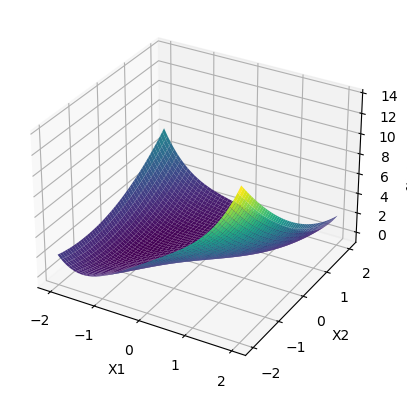

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 定义函数
def f(x):
    return 0.25 * x[0]**4 + 0.5 * x[1]**2 - x[0]*x[1] + x[0] - x[1]

# 创建一个网格来绘制函数
x1 = np.linspace(-2, 2, 400)
x2 = np.linspace(-2, 2, 400)
X1, X2 = np.meshgrid(x1, x2)
Z = f(np.array([X1, X2]))

# 绘制三维图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis')

# 绘制坐标轴
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('f(X1, X2)')

# 显示图形
plt.show()

In [17]:
import numpy as np
from scipy.optimize import fsolve

# 定义目标函数的梯度
def func(x):
    return (x[0]**3 - x[1] + 1, -x[0] + x[1] - 1)

# 可以选择一个合理的初始猜测
initial_guess = np.array([1.5, 1])

# 解方程组找到局部最小点
solution = fsolve(func, initial_guess)

print("局部最小点的近似位置:", solution)

# 计算局部最小点处的函数值
min_point_value = f(solution)
print("局部最小点的函数值为:", min_point_value)

局部最小点的近似位置: [1. 2.]
局部最小点的函数值为: -0.75
